We use VAR models when two or more time-series data have an affect on each other and can be used together to make a prediction for any of the two series.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'
sp = pd.read_csv('Data/PCEPersonalSpending.csv', index_col = 0, parse_dates=True)
sp.index.freq = 'MS'

In [4]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [5]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [6]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [7]:
df = df.join(sp)

In [8]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [9]:
# drop null values
df.dropna(inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Money     252 non-null    float64
 1   Spending  252 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


<Axes: xlabel='Date'>

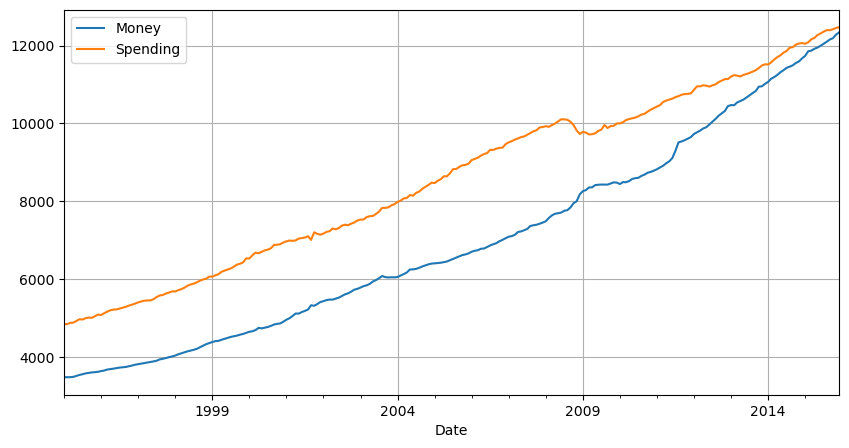

In [11]:
df.plot(figsize = (10, 5), grid = True, legend = True)

In [12]:
# function for generating ADF interpretation report
# we use this to check if the time-series data is stationary
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('\nConclusion:')
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('\nConclusion:')
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044

Conclusion:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [14]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019

Conclusion:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Carry out differencing to make data stationary

In [15]:
df_transformed = df.diff()

In [16]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367

Conclusion:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [17]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00

Conclusion:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
## Money is still not stationary so we need to difference it again
df_transformed = df_transformed.diff().dropna()

In [19]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [20]:
# check for stationaity
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00

Conclusion:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00

Conclusion:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [22]:
'''
Both columns are stationary after being differentiated twice.
'''

'\nBoth columns are stationary after being differentiated twice.\n'

In [23]:
# Num of observations
nobs = 12

In [24]:
train = df_transformed[:-nobs]    # start = begging of df --> go to -12 from the end
test = df_transformed[-nobs:]     # start from -12 and go to the end

In [26]:
start = len(train)
end = start + len(test) - 1

### GRIDSEARCH for finding the order 'p' for VAR Model

In [27]:
model = VAR(train)

for p in range(1, 8):
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 14.178610495220896


ORDER 2
AIC: 13.955189367163705


ORDER 3
AIC: 13.849518291541038


ORDER 4
AIC: 13.827950574458281


ORDER 5
AIC: 13.78730034460964


ORDER 6
AIC: 13.799076756885807


ORDER 7
AIC: 13.797638727913972




In [28]:
# order 5 has the lowest AIC value
model = model.fit(5)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Sep, 2023
Time:                     13:01:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

## Make Predictions
Making predictions off a VAR model is a bit more complicated as we need to pass the previous values as an ndarray of size (p x k). <br>
In this case p = 5, k = 2(for 2 series).

In [30]:
# grab 5 lagges values right before the test starts
lagged_values = train.values[-5:]

In [34]:
# save forecasted results
z = model.forecast(y = lagged_values, steps = 12)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [35]:
# z is a numpy array so we need to convert it to a df first
idx = pd.date_range('2015-01-01', periods=12, freq='MS')   # create index corres to test set for df

In [36]:
df_forecast = pd.DataFrame(data=z, index=idx, columns=['Money_2d', 'Spending_2d'])
df_forecast

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


### Reverse the differencing Transformation

In [37]:
'''
To reverse the differencing we do the following:
1. Take a cumulative sum of the currently differentiated data
2. Take last (n) datapoints from the original training data (n = times differentiated) and subtract them
3. Add 2 to 1

'''

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [38]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [39]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [40]:
# plot the forecasted values against the original test values
test_orig = df[-nobs:]

<Axes: xlabel='Date'>

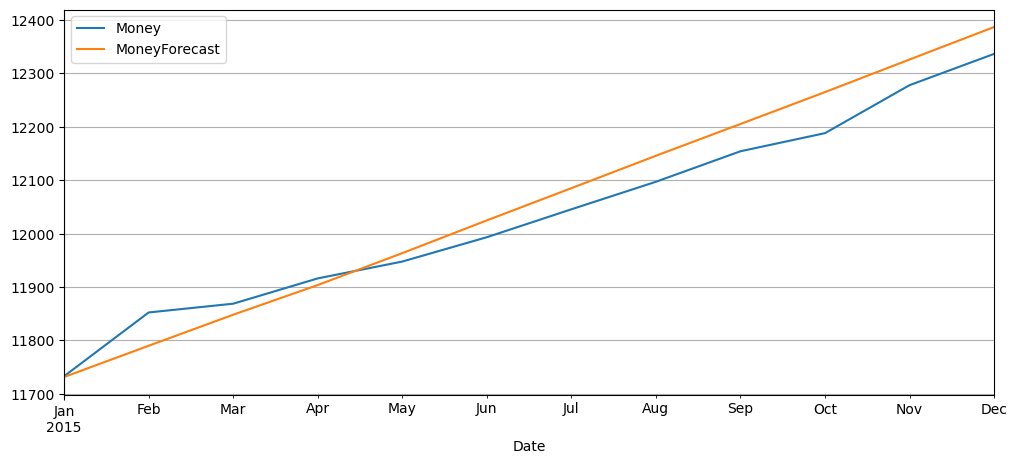

In [42]:
# plot money
test_orig['Money'].plot(figsize = (12, 5), grid = True, legend= True)
df_forecast['MoneyForecast'].plot(figsize = (12, 5), grid = True, legend= True)

<Axes: xlabel='Date'>

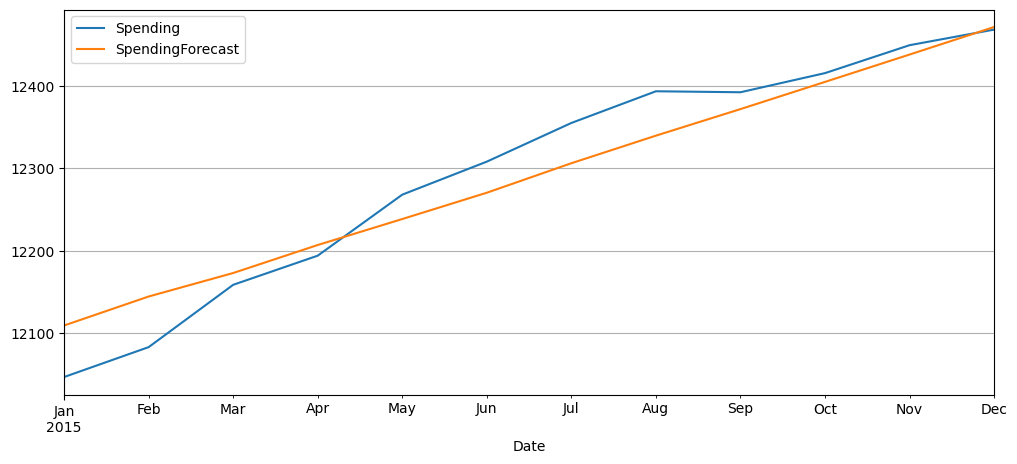

In [43]:
# plot spending
test_orig['Spending'].plot(figsize = (12, 5), grid = True, legend= True)
df_forecast['SpendingForecast'].plot(figsize = (12, 5), grid = True, legend= True)

    ### Calculate 

In [44]:
from statsmodels.tools.eval_measures import rmse

In [45]:
rmse(test_orig['Money'],df_forecast['MoneyForecast'])

43.71049653558893

In [46]:
test_orig['Money'].mean()

12034.008333333333

In [ ]:
rmse(test_orig['Money'],df_forecast['MoneyForecast'])